# PatchTST + AITeamVN/Vietnamese_Embedding Multimodal Stock Prediction

**Architecture:**
- **Text Encoder**: https://huggingface.co/AITeamVN/Vietnamese_Embedding - encode news text
- **Time Series Encoder**: PatchTST - encode price/volume features with patch-based attention
- **Fusion**: Concatenate or Cross-Attention between embeddings from both encoders
- **Decoder**: Fully Connected layers - predict multiple horizons

**Text Selection Logic:**
- Use news from the most recent three days (H, H−1, H−2)

- Apply average pooling per day to aggregate multiple news articles published on the same day

- Use sinusoidal positional encoding to preserve temporal order

- Apply cross-attention, where queries come from the PatchTST output and keys/values come from the news representations

# Install and Import Libraries

In [1]:
!pip install -q torch transformers sentence-transformers accelerate einops

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import timedelta

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

from sentence_transformers import SentenceTransformer
from transformers import PatchTSTConfig, PatchTSTForPrediction

import warnings
warnings.filterwarnings('ignore')

import pickle

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Load Embedding Model

In [5]:
MODEL_NAME = "AITeamVN/Vietnamese_Embedding"

print(f"Loading {MODEL_NAME}...")
embedding_model = SentenceTransformer(MODEL_NAME)
embedding_model = embedding_model.to(device)
embedding_model.eval()

EMBEDDING_DIM = embedding_model.get_sentence_embedding_dimension()
print(f"Model loaded successfully!")
print(f"Embedding dimension: {EMBEDDING_DIM}")

Loading AITeamVN/Vietnamese_Embedding...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/708 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Model loaded successfully!
Embedding dimension: 1024


In [6]:
# Freeze model parameters
FREEZE_MODEL = True

if FREEZE_MODEL:
    for param in embedding_model.parameters():
        param.requires_grad = False
    print("Embedding model parameters frozen")

Embedding model parameters frozen


# Load Datasets

In [7]:
# Load news data
news_df = pd.read_csv("merged_kaggle_collected_news.csv")
news_df['date'] = pd.to_datetime(news_df['date'])

# Sort by date
news_df = news_df.sort_values('date').reset_index(drop=True)

print(f"News data shape: {news_df.shape}")
print(f"Date range: {news_df['date'].min()} to {news_df['date'].max()}")
print(f"\nColumns: {news_df.columns.tolist()}")

News data shape: (13739, 5)
Date range: 2019-12-16 00:00:00 to 2025-10-20 00:00:00

Columns: ['date', 'content', 'content_clean', 'title', 'url']


In [8]:
news_df

,date,content,content_clean,title,url
0,2019-12-16,“Thương hiệu dẫn đầu Việt Nam – Vietnam Leadin...,Thương hiệu dẫn đầu Việt Nam Vietnam Leading B...,BVSC nhận “Top 10 thương hiệu dẫn đầu Việt Nam...,https://baodautu.vn/bvsc-nhan-top-10-thuong-hi...
1,2019-12-16,"Tính đến hết tháng 11/2019, vốn hóa thị trườn...","Tính đến hết tháng 11/2019, vốn hóa thị trường...","Thị trường chứng khoán: Thanh khoản muốn tăng,...",https://baodautu.vn/thi-truong-chung-khoan-tha...
2,2019-12-17,Vàng miếng SJC tại Vàng bạc Đá quý Sài Gòn tiế...,Vàng miếng SJC tại Vàng bạc Đá quý Sài Gòn tiế...,"Giá vàng 14/12 tiếp tục tăng, đồng bảng Anh lậ...",https://baodautu.vn/gia-vang-1412-tiep-tuc-tan...
3,2019-12-20,Lệnh vào nhấp nháy liên tục trên bảng điện tại...,Lệnh vào nhấp nháy liên tục trên bảng điện tại...,Thị trường chứng khoán: Trăn trở khi penny dậy...,https://baodautu.vn/thi-truong-chung-khoan-tra...
4,2019-12-23,Chứng khoán Trung Quốc đại lục mở phiên khá ảm...,Chứng khoán Trung Quốc đại lục mở phiên khá ảm...,Chứng khoán Trung Quốc vẫn yên ắng sau tin cắt...,https://baodautu.vn/chung-khoan-trung-quoc-van...
...,...,...,...,...,...
13734,2025-10-18,"Giá vàng tuần qua biến động mạnh, liên tục phá...","Giá vàng tuần qua biến động mạnh, liên tục phá...",Nhìn lại tuần bùng nổ của giá vàng,https://laodong.vn/tien-te-dau-tu/nhin-lai-tua...
13735,2025-10-19,"Giá vàng SJC giảm 0,47%. Giá vàng thế giới giả...","Giá vàng SJC giảm 0,47%. Giá vàng thế giới giả...",Giá vàng SJC giảm theo thế giới,https://vneconomy.vn/gia-vang-sjc-giam-theo-th...
13736,2025-10-19,Giá vàng thế giới chốt tuần ở mức cao chót vót...,Giá vàng thế giới chốt tuần ở mức cao chót vót...,"Trải qua tuần tăng ""nóng"", các chuyên gia vẫn ...",https://nhandan.vn/trai-qua-tuan-tang-nong-cac...
13737,2025-10-20,ACB công bố kết quả kinh doanh quý 3 với lợi n...,ACB công bố kết quả kinh doanh quý 3 với lợi n...,Quý 3/2025: ACB duy trì tăng trưởng ổn định nă...,https://vneconomy.vn/quy-32025-acb-duy-tri-tan...


In [9]:
# Check news per day distribution
news_per_day = news_df.groupby('date').size()
print(f"\nNews statistics:")
print(f"  Total unique dates with news: {len(news_per_day)}")
print(f"  Mean news per day: {news_per_day.mean():.2f}")
print(f"  Max news per day: {news_per_day.max()}")
print(f"  Min news per day: {news_per_day.min()}")


News statistics:
  Total unique dates with news: 2130
  Mean news per day: 6.45
  Max news per day: 24
  Min news per day: 1


In [12]:
# Group news by date - keep as list of articles per date
news_by_date = news_df.groupby('date')['content_clean'].apply(list).to_dict()

print(f"Created news lookup for {len(news_by_date)} dates")
print(f"Sample dates: {list(news_by_date.keys())[:3]}")

Created news lookup for 2130 dates
Sample dates: [Timestamp('2019-12-16 00:00:00'), Timestamp('2019-12-17 00:00:00'), Timestamp('2019-12-20 00:00:00')]


In [13]:
# Load stock price data
dataset = pd.read_csv("dataset_ACB_fullFeatures.csv")

In [14]:
dataset.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'ticker', 'field',
       'RSI_14', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'MACD_SIGNAL',
       'MACD_HIST', 'ADX_14', 'STOCH_K', 'STOCH_D', 'STOCHRSI_14',
       'GDP × 10^9 (USD)', 'CPI', 'usd_vnd'],
      dtype='object')

In [15]:
dataset['date'] = pd.to_datetime(dataset['date'])
dataset.set_index('date', inplace=True)

# Drop unnecessary columns if exist
cols_to_drop = ['ticker', 'field']
dataset.drop(columns=[c for c in cols_to_drop if c in dataset.columns], inplace=True)

print(f"Stock data shape: {dataset.shape}")
print(f"Date range: {dataset.index.min()} to {dataset.index.max()}")

Stock data shape: (1442, 19)
Date range: 2020-01-02 00:00:00 to 2025-10-20 00:00:00


In [16]:
numeric_vars = ['open', 'high', 'low','close','volume','RSI_14',
                'MA_10', 'MA_50', 'MA_200','MACD','MACD_SIGNAL','MACD_HIST',
                'ADX_14','STOCH_K','STOCH_D',
                'GDP × 10^9 (USD)', 'CPI', 'usd_vnd']
for var in numeric_vars:
    dataset[var] = pd.to_numeric(dataset[var], errors='coerce')

In [17]:
dataset.shape, dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2020-01-02 to 2025-10-20
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open              1442 non-null   float64
 1   high              1442 non-null   float64
 2   low               1442 non-null   float64
 3   close             1442 non-null   float64
 4   volume            1442 non-null   float64
 5   RSI_14            1442 non-null   float64
 6   MA_10             1442 non-null   float64
 7   MA_50             1442 non-null   float64
 8   MA_200            1442 non-null   float64
 9   MACD              1442 non-null   float64
 10  MACD_SIGNAL       1442 non-null   float64
 11  MACD_HIST         1442 non-null   float64
 12  ADX_14            1442 non-null   float64
 13  STOCH_K           1442 non-null   float64
 14  STOCH_D           1442 non-null   float64
 15  STOCHRSI_14       1442 non-null   float64
 16  GDP × 10^9 (USD)  1442 n

((1442, 19), None)

# Prepare Data

In [18]:
data = dataset.copy()

# Lưu data gốc TRƯỚC KHI SCALE
data_original = data.copy()

train_ratio = 0.6
valid_ratio = 0.15

n = len(data)
train_end = int(train_ratio * n)
valid_end = int((train_ratio + valid_ratio) * n)

train_df = data.iloc[:train_end].copy()
valid_df = data.iloc[train_end:valid_end].copy()
test_df  = data.iloc[valid_end:].copy()

# Data gốc cho evaluation
train_df_original = data_original.iloc[:train_end].copy()
valid_df_original = data_original.iloc[train_end:valid_end].copy()
test_df_original  = data_original.iloc[valid_end:].copy()

print(f"Total: {n}")
print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Total: 1442
Train: 865, Valid: 216, Test: 361


In [19]:
# Features dùng RobustScaler (KHÔNG bao gồm close)
features_robust = ['open', 'high', 'low', 'volume', 'RSI_14',
                   'MA_10', 'MA_50', 'MA_200', 'MACD', 'MACD_SIGNAL', 'MACD_HIST',
                   'ADX_14', 'STOCH_K', 'STOCH_D', 'STOCHRSI_14',
                   'GDP × 10^9 (USD)', 'CPI', 'usd_vnd']

# RobustScaler cho các features khác
scaler_robust = RobustScaler().fit(train_df[features_robust])

train_df[features_robust] = scaler_robust.transform(train_df[features_robust])
valid_df[features_robust] = scaler_robust.transform(valid_df[features_robust])
test_df[features_robust]  = scaler_robust.transform(test_df[features_robust])

# StandardScaler cho close
scaler_close = StandardScaler().fit(train_df[['close']])

train_df['close'] = scaler_close.transform(train_df[['close']])
valid_df['close'] = scaler_close.transform(valid_df[['close']])
test_df['close']  = scaler_close.transform(test_df[['close']])

print(f"\nScaling summary:")
print(f"  RobustScaler: {features_robust}")
print(f"  StandardScaler: ['close']")


Scaling summary:
  RobustScaler: ['open', 'high', 'low', 'volume', 'RSI_14', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ADX_14', 'STOCH_K', 'STOCH_D', 'STOCHRSI_14', 'GDP × 10^9 (USD)', 'CPI', 'usd_vnd']
  StandardScaler: ['close']


# Pre-encode Text with AITeamVN/Vietnamese_Embedding (multi-day)

In [20]:
def encode_text(text, model, device):
    """
    Encode a single text using SentenceTransformer.
    Returns the sentence embedding.
    """
    if not text or len(str(text).strip()) == 0:
        return torch.zeros(EMBEDDING_DIM)

    with torch.no_grad():
        embedding = model.encode(
            text,
            convert_to_tensor=True,
            device=device
        )

    return embedding.cpu()

In [21]:
# Test encoding
test_text = "Thị trường chứng khoán Việt Nam tăng mạnh trong phiên giao dịch hôm nay."
test_embedding = encode_text(test_text, embedding_model, device)
print(f"Test embedding shape: {test_embedding.shape}")
print(test_embedding)

Test embedding shape: torch.Size([1024])
tensor([0.0120, 0.0814, 0.0082,  ..., 0.0377, 0.0186, 0.0193])


In [22]:
def encode_articles_with_average_pool(articles_list, model, device):
    """
    Encode multiple articles and return their average embedding.
    """
    if not articles_list or len(articles_list) == 0:
        return torch.zeros(EMBEDDING_DIM)

    valid_articles = [a for a in articles_list if a and len(str(a).strip()) > 0]

    if len(valid_articles) == 0:
        return torch.zeros(EMBEDDING_DIM)

    with torch.no_grad():
        embeddings = model.encode(
            valid_articles,
            convert_to_tensor=True,
            device=device,
            batch_size=32
        )
        avg_embedding = embeddings.mean(dim=0)

    return avg_embedding.cpu()

In [30]:
# Pre-encode all dates - using AVERAGE POOLING for multiple articles per day
print(f"Pre-encoding all news with average pooling using {MODEL_NAME}...")

text_embeddings_cache = {}

for i, (date, articles_list) in enumerate(news_by_date.items()):
    # Average pool all articles for this day
    avg_embedding = encode_articles_with_average_pool(articles_list, embedding_model, device)
    text_embeddings_cache[date] = avg_embedding

    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{len(news_by_date)} dates")

print(f"\nPre-encoded {len(text_embeddings_cache)} date embeddings (with average pooling)")
print(f"Embedding dimension: {EMBEDDING_DIM}")

Pre-encoding all news with average pooling using AITeamVN/Vietnamese_Embedding...
  Processed 200/2130 dates
  Processed 400/2130 dates
  Processed 600/2130 dates
  Processed 800/2130 dates
  Processed 1000/2130 dates
  Processed 1200/2130 dates
  Processed 1400/2130 dates
  Processed 1600/2130 dates
  Processed 1800/2130 dates
  Processed 2000/2130 dates

Pre-encoded 2130 date embeddings (with average pooling)
Embedding dimension: 1024


In [ ]:
# Save cache sau khi encode xong
with open('text_embeddings_cache.pkl', 'wb') as f:
    pickle.dump(text_embeddings_cache, f)

In [32]:
# Load lại lần sau (chỉ vài giây)
with open('text_embeddings_cache.pkl', 'rb') as f:
    text_embeddings_cache = pickle.load(f)

#Sinusoidal Positional Encoding

In [35]:
class SinusoidalPositionalEncoding(nn.Module):
    """
    Sinusoidal Positional Encoding for temporal awareness.

    Cho phép model phân biệt tin tức ngày H (gần nhất), H-1, H-2 (xa hơn).

    PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    def __init__(self, d_model, max_len=10):
        super(SinusoidalPositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer (not a parameter, but saved with model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)

        Returns:
            x + positional encoding
        """
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :].unsqueeze(0)

# Dataset Class with News

In [36]:
# Configuration for multi-day news
NEWS_LOOKBACK_DAYS = 3  # Use news from H, H-1, H-2

print(f"News lookback: {NEWS_LOOKBACK_DAYS} days")
print(f"For predicting H+1, H+4, ... will use news from days: H, H-1, H-2")

News lookback: 3 days
For predicting H+1, H+4, ... will use news from days: H, H-1, H-2


In [37]:
def get_multiday_news_embeddings(target_date, text_embeddings_cache,
                                  num_days=3, embedding_dim=768, max_search_days=30):
    """
    Get news embeddings for multiple days (H, H-1, H-2, ...).
    """
    if not isinstance(target_date, pd.Timestamp):
        target_date = pd.Timestamp(target_date)

    embeddings = []

    for day_offset in range(num_days):
        check_date = target_date - timedelta(days=day_offset)

        found_embedding = None
        for search_offset in range(max_search_days + 1):
            search_date = check_date - timedelta(days=search_offset)
            if search_date in text_embeddings_cache:
                found_embedding = text_embeddings_cache[search_date]
                break

        if found_embedding is None:
            found_embedding = torch.zeros(embedding_dim)

        embeddings.append(found_embedding)

    return torch.stack(embeddings, dim=0)

In [38]:
class StockMultiDayNewsDataset(Dataset):
    """
    Dataset with MULTI-DAY news embeddings.
    """
    def __init__(self, df, df_original, feature_cols,
                 text_embeddings_cache,
                 horizons=[1, 4, 8, 12, 24], window=36,
                 embedding_dim=768, num_news_days=3, max_lookback_days=30):

        self.samples = []
        self.horizons = horizons
        self.embedding_dim = embedding_dim
        self.num_news_days = num_news_days

        features = df[feature_cols].values
        close_original = df_original['close'].values
        dates = df.index

        n = len(df)
        for i in range(n - window - max(horizons)):
            X = features[i : i + window]
            last_date_in_window = dates[i + window - 1]

            text_emb = get_multiday_news_embeddings(
                last_date_in_window,
                text_embeddings_cache,
                num_days=num_news_days,
                embedding_dim=embedding_dim,
                max_search_days=max_lookback_days
            )

            base_price = close_original[i + window - 1]

            y = []
            actual_prices = []
            for h in horizons:
                future_price = close_original[i + window - 1 + h]
                cumulative_return = (future_price - base_price) / base_price
                y.append(cumulative_return)
                actual_prices.append(future_price)

            self.samples.append((
                torch.tensor(X, dtype=torch.float32),
                text_emb,
                torch.tensor(y, dtype=torch.float32),
                base_price,
                torch.tensor(actual_prices, dtype=torch.float32)
            ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# Multimodal Model: PatchTST + AITeamVN/Vietnamese_Embedding

## Fusion: concatenate (torch.cat)

In [39]:
# Concat model (baseline)
class PatchTSTConcatMultiDayNews(nn.Module):
    """
    PatchTST + Concat model (baseline comparison).
    """
    def __init__(self, num_input_channels, context_length,
                 patch_len=16, stride=8, d_model=64, n_heads=4,
                 num_encoder_layers=2, dropout=0.3,
                 num_horizons=5, embedding_dim=768, num_news_days=3,
                 text_proj_dim=64, use_text=True):
        super(PatchTSTConcatMultiDayNews, self).__init__()

        self.use_text = use_text
        self.d_model = d_model

        config = PatchTSTConfig(
            num_input_channels=num_input_channels,
            context_length=context_length,
            patch_length=patch_len,
            patch_stride=stride,
            d_model=d_model,
            num_attention_heads=n_heads,
            num_hidden_layers=num_encoder_layers,
            dropout=dropout,
            prediction_length=1,
        )
        self.patchtst = PatchTSTForPrediction(config)

        if use_text:
            self.positional_encoding = SinusoidalPositionalEncoding(
                d_model=embedding_dim,
                max_len=num_news_days + 5
            )

            self.text_projection = nn.Sequential(
                nn.Linear(embedding_dim, text_proj_dim * 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(text_proj_dim * 2, text_proj_dim),
                nn.GELU()
            )

            fusion_dim = d_model + text_proj_dim
        else:
            fusion_dim = d_model

        self.decoder = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, num_horizons)
        )

    def forward(self, x_ts, x_text=None):
        batch_size = x_ts.size(0)

        patchtst_out = self.patchtst(past_values=x_ts, output_hidden_states=True)
        hidden = patchtst_out.hidden_states[-1]
        ts_embedding = hidden.mean(dim=[1, 2])  # (batch, d_model)

        if self.use_text and x_text is not None:
            news_with_pos = self.positional_encoding(x_text)
            news_avg = news_with_pos.mean(dim=1)  # (batch, embedding_dim)
            text_proj = self.text_projection(news_avg)
            fused = torch.cat([ts_embedding, text_proj], dim=-1)
        else:
            fused = ts_embedding

        predictions = self.decoder(fused)
        return predictions, None

##Cross attention

In [40]:
class PatchTSTCrossAttentionMultiDayNews(nn.Module):
    """
    PatchTST + Cross-Attention model với Multi-Day News Integration.

    Pipeline:
    1. News Encoder: Multi-day news → Positional Encoding → FFN
    2. Time-Series Encoder: PatchTST encodes historical price data
    3. Cross-Attention: Query = PatchTST output, Key = Value = News
    4. Fusion & Prediction: Concatenate and decode
    """
    def __init__(self, num_input_channels, context_length,
                 patch_len=16, stride=8, d_model=64, n_heads=4,
                 num_encoder_layers=2, dropout=0.3,
                 num_horizons=5, embedding_dim=768, num_news_days=3,
                 num_attention_heads=4, use_text=True):
        super(PatchTSTCrossAttentionMultiDayNews, self).__init__()

        self.use_text = use_text
        self.d_model = d_model
        self.num_news_days = num_news_days

        # ===== PatchTST Backbone =====
        config = PatchTSTConfig(
            num_input_channels=num_input_channels,
            context_length=context_length,
            patch_length=patch_len,
            patch_stride=stride,
            d_model=d_model,
            num_attention_heads=n_heads,
            num_hidden_layers=num_encoder_layers,
            dropout=dropout,
            prediction_length=1,
        )
        self.patchtst = PatchTSTForPrediction(config)

        if use_text:
            # ===== News Encoder =====
            self.positional_encoding = SinusoidalPositionalEncoding(
                d_model=embedding_dim,
                max_len=num_news_days + 5
            )

            self.news_ffn = nn.Sequential(
                nn.Linear(embedding_dim, d_model * 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(d_model * 2, d_model),
                nn.GELU()
            )

            # ===== Cross-Attention =====
            self.cross_attention = nn.MultiheadAttention(
                embed_dim=d_model,
                num_heads=num_attention_heads,
                dropout=dropout,
                batch_first=True
            )

            self.attn_layer_norm = nn.LayerNorm(d_model)

            fusion_dim = d_model * 2
        else:
            fusion_dim = d_model

        # ===== Decoder =====
        self.decoder = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim // 2, num_horizons)
        )

    def forward(self, x_ts, x_text=None):
        """
        Args:
            x_ts: (batch, seq_len, num_input_channels)
            x_text: (batch, num_news_days, embedding_dim)
        """
        batch_size = x_ts.size(0)

        # ===== PatchTST Encoding =====
        patchtst_out = self.patchtst(past_values=x_ts, output_hidden_states=True)
        hidden = patchtst_out.hidden_states[-1]  # (batch, channels, num_patches, d_model)

        # Reshape for attention: (batch, num_patches * channels, d_model)
        hidden_flat = hidden.view(batch_size, -1, self.d_model)

        # Global average pooling for ts_embedding
        ts_embedding = hidden_flat.mean(dim=1)  # (batch, d_model)

        attention_weights = None

        if self.use_text and x_text is not None:
            # ===== Encode News =====
            news_with_pos = self.positional_encoding(x_text)
            news_proj = self.news_ffn(news_with_pos)  # (batch, num_news_days, d_model)

            # ===== Cross-Attention =====
            # Query = PatchTST patches, Key = Value = News
            cross_attn_out, attention_weights = self.cross_attention(
                query=hidden_flat,   # (batch, num_patches*channels, d_model)
                key=news_proj,       # (batch, num_news_days, d_model)
                value=news_proj      # (batch, num_news_days, d_model)
            )

            cross_attn_out = self.attn_layer_norm(cross_attn_out + hidden_flat)
            cross_attn_embedding = cross_attn_out.mean(dim=1)  # (batch, d_model)

            fused = torch.cat([ts_embedding, cross_attn_embedding], dim=-1)
        else:
            fused = ts_embedding

        predictions = self.decoder(fused)

        return predictions, attention_weights

#EarlyStopping class

In [41]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.count = 0
        self.best_state = None

    def step(self, metric, model):
        improved = (self.best is None) or (metric < self.best - self.min_delta)
        if improved:
            self.best = metric
            self.count = 0
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.count += 1
        return improved, self.count >= self.patience

# Training Configuration

In [69]:
# Hyperparameters
L_VALUES = [24, 36, 48, 60, 72, 84, 96]  # PatchTST cần L >= patch_len
H_LIST = [1, 4, 7, 10, 14, 21]

# PatchTST hyperparameters
PATCH_LEN = 16
STRIDE = 4
D_MODEL = 32
N_HEADS = 8
NUM_ENCODER_LAYERS = 2
DROPOUT = 0.4

# Model configuration
USE_TEXT = True
USE_CROSS_ATTENTION = True  # True = Cross-Attention, False = Concat

print(f"\n" + "="*60)
print("CONFIGURATION")
print("="*60)
print(f"  L values: {L_VALUES}")
print(f"  Horizons: {H_LIST}")
print(f"  Patch length: {PATCH_LEN}, Stride: {STRIDE}")
print(f"  D_MODEL: {D_MODEL}, N_HEADS: {N_HEADS}")
print(f"  Use text: {USE_TEXT}")
print(f"  Use cross-attention: {USE_CROSS_ATTENTION}")
print(f"  News lookback days: {NEWS_LOOKBACK_DAYS}")


CONFIGURATION
  L values: [24, 36, 48, 60, 72, 84, 96]
  Horizons: [1, 4, 7, 10, 14, 21]
  Patch length: 16, Stride: 4
  D_MODEL: 32, N_HEADS: 8
  Use text: True
  Use cross-attention: True
  News lookback days: 3


In [70]:
feature_cols = features_robust + ['close']
print(f"\nFeature columns ({len(feature_cols)}): {feature_cols}")


Feature columns (19): ['open', 'high', 'low', 'volume', 'RSI_14', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ADX_14', 'STOCH_K', 'STOCH_D', 'STOCHRSI_14', 'GDP × 10^9 (USD)', 'CPI', 'usd_vnd', 'close']


In [71]:
best_L = None
best_valid_loss = float('inf')
best_model_state = None
results_by_L = {}

# Training Loop

##Fusion: concatenate

In [48]:
for L in L_VALUES:
    print(f"\n{'='*60}")
    print(f"TRAINING PatchTST WITH L = {L}")
    print(f"{'='*60}")

    if PATCH_LEN > L:
        print(f"Skipping L={L}: patch_len ({PATCH_LEN}) > L ({L})")
        continue

    train_dataset = StockMultiDayNewsDataset(
        train_df, train_df_original, feature_cols,
        text_embeddings_cache,
        horizons=H_LIST, window=L,
        embedding_dim=EMBEDDING_DIM,
        num_news_days=NEWS_LOOKBACK_DAYS
    )
    valid_dataset = StockMultiDayNewsDataset(
        valid_df, valid_df_original, feature_cols,
        text_embeddings_cache,
        horizons=H_LIST, window=L,
        embedding_dim=EMBEDDING_DIM,
        num_news_days=NEWS_LOOKBACK_DAYS
    )

    print(f"Train samples: {len(train_dataset)}, Valid samples: {len(valid_dataset)}")

    if len(train_dataset) < 10 or len(valid_dataset) < 5:
        print(f"Skipping L={L}: Not enough samples")
        continue

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

    num_features = len(feature_cols)

    if USE_CROSS_ATTENTION:
        model = PatchTSTCrossAttentionMultiDayNews(
            num_input_channels=num_features,
            context_length=L,
            patch_len=PATCH_LEN,
            stride=STRIDE,
            d_model=D_MODEL,
            n_heads=N_HEADS,
            num_encoder_layers=NUM_ENCODER_LAYERS,
            dropout=DROPOUT,
            num_horizons=len(H_LIST),
            embedding_dim=EMBEDDING_DIM,
            num_news_days=NEWS_LOOKBACK_DAYS,
            num_attention_heads=4,
            use_text=USE_TEXT
        ).to(device)
    else:
        model = PatchTSTConcatMultiDayNews(
            num_input_channels=num_features,
            context_length=L,
            patch_len=PATCH_LEN,
            stride=STRIDE,
            d_model=D_MODEL,
            n_heads=N_HEADS,
            num_encoder_layers=NUM_ENCODER_LAYERS,
            dropout=DROPOUT,
            num_horizons=len(H_LIST),
            embedding_dim=EMBEDDING_DIM,
            num_news_days=NEWS_LOOKBACK_DAYS,
            text_proj_dim=128,
            use_text=USE_TEXT
        ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    early_stopping = EarlyStopping(patience=7, min_delta=1e-5)

    EPOCHS = 100
    train_losses, valid_losses = [], []

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_train = 0.0
        for X_batch, text_batch, y_batch, _, _ in train_loader:
            X_batch = X_batch.to(device)
            text_batch = text_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()

            if USE_TEXT:
                preds, _ = model(X_batch, text_batch)
            else:
                preds, _ = model(X_batch)

            loss = criterion(preds, y_batch)
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train += loss.item() * X_batch.size(0)

        train_loss = running_train / len(train_dataset)
        train_losses.append(train_loss)

        model.eval()
        running_valid = 0.0
        with torch.no_grad():
            for X_batch, text_batch, y_batch, _, _ in valid_loader:
                X_batch = X_batch.to(device)
                text_batch = text_batch.to(device)
                y_batch = y_batch.to(device)

                if USE_TEXT:
                    preds, _ = model(X_batch, text_batch)
                else:
                    preds, _ = model(X_batch)

                loss = criterion(preds, y_batch)
                running_valid += loss.item() * X_batch.size(0)

        valid_loss = running_valid / len(valid_dataset)
        valid_losses.append(valid_loss)

        scheduler.step(valid_loss)
        improved, should_stop = early_stopping.step(valid_loss, model)

        if epoch % 10 == 0 or improved:
            mark = "*" if improved else ""
            print(f"  Epoch {epoch:3d}: Train={train_loss:.6f}, Valid={valid_loss:.6f} {mark}")

        if should_stop:
            print(f"  Early stopping at epoch {epoch}")
            break

    results_by_L[L] = {
        'valid_loss': early_stopping.best,
        'model_state': early_stopping.best_state,
        'train_losses': train_losses,
        'valid_losses': valid_losses
    }

    if early_stopping.best < best_valid_loss:
        best_valid_loss = early_stopping.best
        best_L = L
        best_model_state = early_stopping.best_state

    print(f"  Best valid loss for L={L}: {early_stopping.best:.6f}")

print(f"\n{'='*60}")
print(f"BEST MODEL: L={best_L} with valid_loss={best_valid_loss:.6f}")
print(f"{'='*60}")


TRAINING PatchTST WITH L = 24
Train samples: 820, Valid samples: 171
Model parameters: 397,927
  Epoch   1: Train=0.005236, Valid=0.001570 *
  Epoch   2: Train=0.004608, Valid=0.001340 *
  Epoch   7: Train=0.004448, Valid=0.001320 *
  Epoch  10: Train=0.004190, Valid=0.001210 *
  Early stopping at epoch 17
  Best valid loss for L=24: 0.001210

TRAINING PatchTST WITH L = 36
Train samples: 808, Valid samples: 159
Model parameters: 397,927
  Epoch   1: Train=0.005075, Valid=0.001371 *
  Epoch   3: Train=0.004487, Valid=0.001335 *
  Epoch   6: Train=0.004423, Valid=0.001321 *
  Epoch  10: Train=0.004057, Valid=0.001753 
  Early stopping at epoch 13
  Best valid loss for L=36: 0.001321

TRAINING PatchTST WITH L = 48
Train samples: 796, Valid samples: 147
Model parameters: 397,927
  Epoch   1: Train=0.004852, Valid=0.001522 *
  Epoch   2: Train=0.004282, Valid=0.001391 *
  Early stopping at epoch 9
  Best valid loss for L=48: 0.001391

TRAINING PatchTST WITH L = 60
Train samples: 784, Valid

##Cross attention

In [72]:
for L in L_VALUES:
    print(f"\n{'='*60}")
    print(f"TRAINING PatchTST WITH L = {L}")
    print(f"{'='*60}")

    if PATCH_LEN > L:
        print(f"Skipping L={L}: patch_len ({PATCH_LEN}) > L ({L})")
        continue

    train_dataset = StockMultiDayNewsDataset(
        train_df, train_df_original, feature_cols,
        text_embeddings_cache,
        horizons=H_LIST, window=L,
        embedding_dim=EMBEDDING_DIM,
        num_news_days=NEWS_LOOKBACK_DAYS
    )
    valid_dataset = StockMultiDayNewsDataset(
        valid_df, valid_df_original, feature_cols,
        text_embeddings_cache,
        horizons=H_LIST, window=L,
        embedding_dim=EMBEDDING_DIM,
        num_news_days=NEWS_LOOKBACK_DAYS
    )

    print(f"Train samples: {len(train_dataset)}, Valid samples: {len(valid_dataset)}")

    if len(train_dataset) < 10 or len(valid_dataset) < 5:
        print(f"Skipping L={L}: Not enough samples")
        continue

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

    num_features = len(feature_cols)

    if USE_CROSS_ATTENTION:
        model = PatchTSTCrossAttentionMultiDayNews(
            num_input_channels=num_features,
            context_length=L,
            patch_len=PATCH_LEN,
            stride=STRIDE,
            d_model=D_MODEL,
            n_heads=N_HEADS,
            num_encoder_layers=NUM_ENCODER_LAYERS,
            dropout=DROPOUT,
            num_horizons=len(H_LIST),
            embedding_dim=EMBEDDING_DIM,
            num_news_days=NEWS_LOOKBACK_DAYS,
            num_attention_heads=4,
            use_text=USE_TEXT
        ).to(device)
    else:
        model = PatchTSTConcatMultiDayNews(
            num_input_channels=num_features,
            context_length=L,
            patch_len=PATCH_LEN,
            stride=STRIDE,
            d_model=D_MODEL,
            n_heads=N_HEADS,
            num_encoder_layers=NUM_ENCODER_LAYERS,
            dropout=DROPOUT,
            num_horizons=len(H_LIST),
            embedding_dim=EMBEDDING_DIM,
            num_news_days=NEWS_LOOKBACK_DAYS,
            text_proj_dim=128,
            use_text=USE_TEXT
        ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    early_stopping = EarlyStopping(patience=7, min_delta=1e-5)

    EPOCHS = 100
    train_losses, valid_losses = [], []

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_train = 0.0
        for X_batch, text_batch, y_batch, _, _ in train_loader:
            X_batch = X_batch.to(device)
            text_batch = text_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()

            if USE_TEXT:
                preds, _ = model(X_batch, text_batch)
            else:
                preds, _ = model(X_batch)

            loss = criterion(preds, y_batch)
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train += loss.item() * X_batch.size(0)

        train_loss = running_train / len(train_dataset)
        train_losses.append(train_loss)

        model.eval()
        running_valid = 0.0
        with torch.no_grad():
            for X_batch, text_batch, y_batch, _, _ in valid_loader:
                X_batch = X_batch.to(device)
                text_batch = text_batch.to(device)
                y_batch = y_batch.to(device)

                if USE_TEXT:
                    preds, _ = model(X_batch, text_batch)
                else:
                    preds, _ = model(X_batch)

                loss = criterion(preds, y_batch)
                running_valid += loss.item() * X_batch.size(0)

        valid_loss = running_valid / len(valid_dataset)
        valid_losses.append(valid_loss)

        scheduler.step(valid_loss)
        improved, should_stop = early_stopping.step(valid_loss, model)

        if epoch % 10 == 0 or improved:
            mark = "*" if improved else ""
            print(f"  Epoch {epoch:3d}: Train={train_loss:.6f}, Valid={valid_loss:.6f} {mark}")

        if should_stop:
            print(f"  Early stopping at epoch {epoch}")
            break

    results_by_L[L] = {
        'valid_loss': early_stopping.best,
        'model_state': early_stopping.best_state,
        'train_losses': train_losses,
        'valid_losses': valid_losses
    }

    if early_stopping.best < best_valid_loss:
        best_valid_loss = early_stopping.best
        best_L = L
        best_model_state = early_stopping.best_state

    print(f"  Best valid loss for L={L}: {early_stopping.best:.6f}")

print(f"\n{'='*60}")
print(f"BEST MODEL: L={best_L} with valid_loss={best_valid_loss:.6f}")
print(f"{'='*60}")


TRAINING PatchTST WITH L = 24
Train samples: 820, Valid samples: 171
Model parameters: 154,311
  Epoch   1: Train=0.006779, Valid=0.001443 *
  Epoch   3: Train=0.005246, Valid=0.001396 *
  Epoch   6: Train=0.004805, Valid=0.001361 *
  Epoch  10: Train=0.004545, Valid=0.001284 *
  Epoch  11: Train=0.004520, Valid=0.001220 *
  Early stopping at epoch 18
  Best valid loss for L=24: 0.001220

TRAINING PatchTST WITH L = 36
Train samples: 808, Valid samples: 159
Model parameters: 154,311
  Epoch   1: Train=0.007376, Valid=0.001464 *
  Epoch   2: Train=0.005364, Valid=0.001368 *
  Epoch   4: Train=0.004805, Valid=0.001314 *
  Epoch  10: Train=0.004267, Valid=0.001462 
  Early stopping at epoch 11
  Best valid loss for L=36: 0.001314

TRAINING PatchTST WITH L = 48
Train samples: 796, Valid samples: 147
Model parameters: 154,311
  Epoch   1: Train=0.009796, Valid=0.001456 *
  Epoch   2: Train=0.005791, Valid=0.001421 *
  Epoch   3: Train=0.005141, Valid=0.001379 *
  Epoch   4: Train=0.004970, 

#Plot Training Results

##Fusion: concatenate

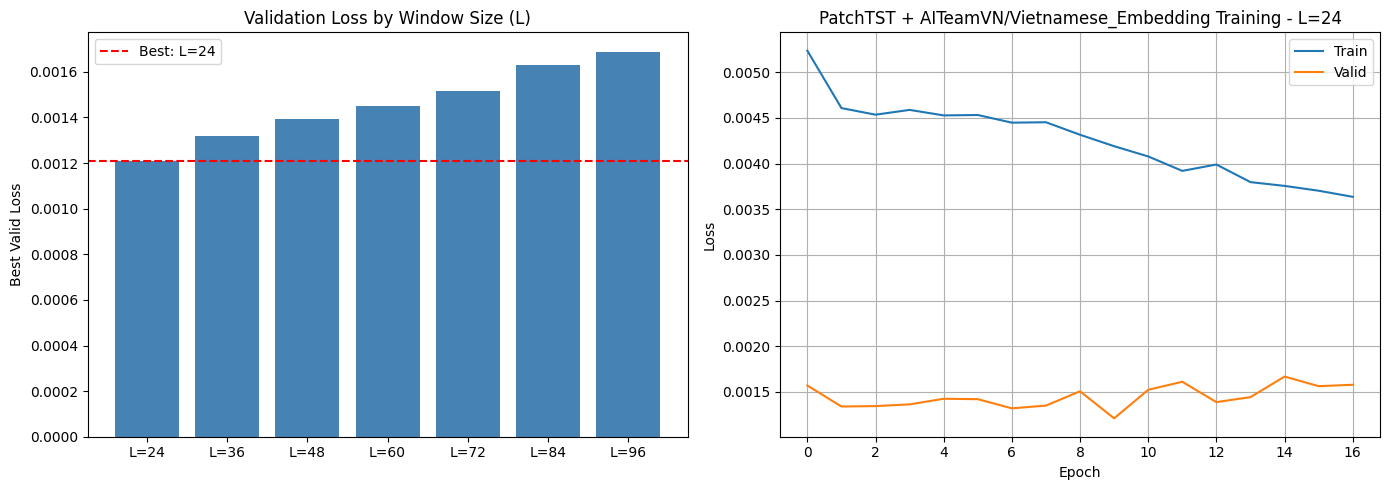

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: So sánh valid loss các L
L_list = list(results_by_L.keys())
valid_losses_list = [results_by_L[L]['valid_loss'] for L in L_list]

axes[0].bar(range(len(L_list)), valid_losses_list, color='steelblue')
axes[0].set_xticks(range(len(L_list)))
axes[0].set_xticklabels([f'L={L}' for L in L_list])
axes[0].set_ylabel('Best Valid Loss')
axes[0].set_title('Validation Loss by Window Size (L)')
axes[0].axhline(y=best_valid_loss, color='red', linestyle='--', label=f'Best: L={best_L}')
axes[0].legend()

# Plot 2: Training curves for best L (style từ code 2)
if best_L in results_by_L:
    axes[1].plot(results_by_L[best_L]['train_losses'], label='Train')
    axes[1].plot(results_by_L[best_L]['valid_losses'], label='Valid')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(f'PatchTST + AITeamVN/Vietnamese_Embedding Training - L={best_L}')
    axes[1].legend()
    axes[1].grid(True)

plt.tight_layout()
plt.show()

##Cross Attention

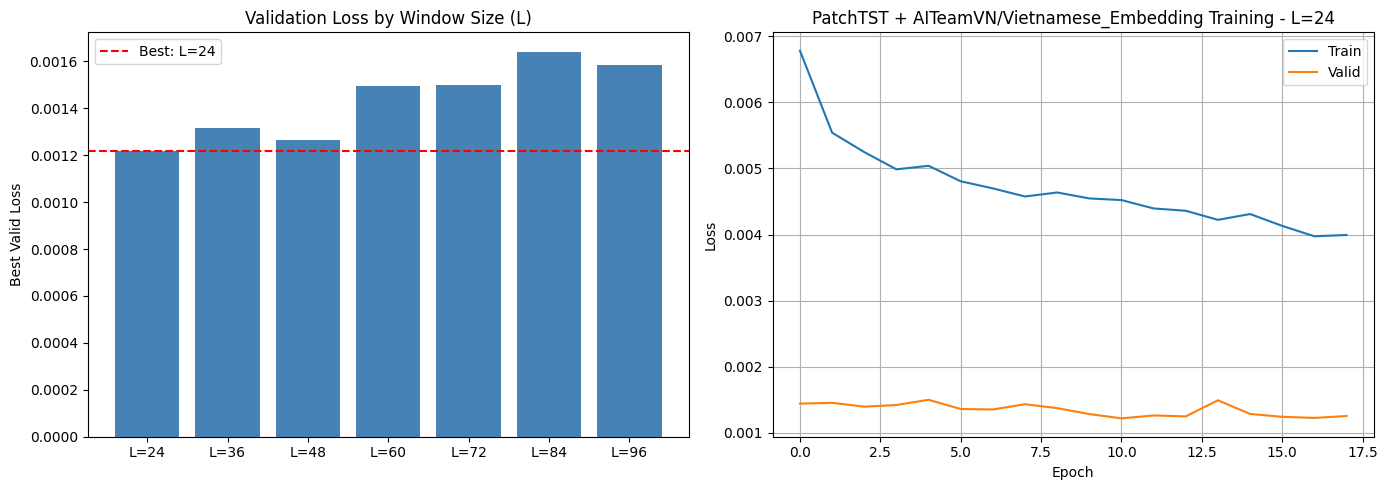

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: So sánh valid loss các L
L_list = list(results_by_L.keys())
valid_losses_list = [results_by_L[L]['valid_loss'] for L in L_list]

axes[0].bar(range(len(L_list)), valid_losses_list, color='steelblue')
axes[0].set_xticks(range(len(L_list)))
axes[0].set_xticklabels([f'L={L}' for L in L_list])
axes[0].set_ylabel('Best Valid Loss')
axes[0].set_title('Validation Loss by Window Size (L)')
axes[0].axhline(y=best_valid_loss, color='red', linestyle='--', label=f'Best: L={best_L}')
axes[0].legend()

# Plot 2: Training curves for best L (style từ code 2)
if best_L in results_by_L:
    axes[1].plot(results_by_L[best_L]['train_losses'], label='Train')
    axes[1].plot(results_by_L[best_L]['valid_losses'], label='Valid')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(f'PatchTST + AITeamVN/Vietnamese_Embedding Training - L={best_L}')
    axes[1].legend()
    axes[1].grid(True)

plt.tight_layout()
plt.show()

# Evaluation on Test Set

In [74]:
test_dataset = StockMultiDayNewsDataset(
    test_df, test_df_original, feature_cols,
    text_embeddings_cache,
    horizons=H_LIST, window=best_L,
    embedding_dim=EMBEDDING_DIM,
    num_news_days=NEWS_LOOKBACK_DAYS
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Test samples: {len(test_dataset)}")

Test samples: 316


In [75]:
num_features = len(feature_cols)

if USE_CROSS_ATTENTION:
    final_model = PatchTSTCrossAttentionMultiDayNews(
        num_input_channels=num_features,
        context_length=best_L,
        patch_len=PATCH_LEN,
        stride=STRIDE,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        num_encoder_layers=NUM_ENCODER_LAYERS,
        dropout=DROPOUT,
        num_horizons=len(H_LIST),
        embedding_dim=EMBEDDING_DIM,
        num_news_days=NEWS_LOOKBACK_DAYS,
        num_attention_heads=4,
        use_text=USE_TEXT
    ).to(device)
else:
    final_model = PatchTSTConcatMultiDayNews(
        num_input_channels=num_features,
        context_length=best_L,
        patch_len=PATCH_LEN,
        stride=STRIDE,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        num_encoder_layers=NUM_ENCODER_LAYERS,
        dropout=DROPOUT,
        num_horizons=len(H_LIST),
        embedding_dim=EMBEDDING_DIM,
        num_news_days=NEWS_LOOKBACK_DAYS,
        text_proj_dim=128,
        use_text=USE_TEXT
    ).to(device)

final_model.load_state_dict(best_model_state)
final_model.eval()
print("Best model loaded")

Best model loaded


In [76]:
all_preds = []
all_targets = []
all_base_prices = []
all_actual_prices = []
all_attention_weights = []

with torch.no_grad():
    for X_batch, text_batch, y_batch, base_price_batch, actual_price_batch in test_loader:
        X_batch = X_batch.to(device)
        text_batch = text_batch.to(device)

        if USE_TEXT:
            preds, attn_weights = final_model(X_batch, text_batch)
        else:
            preds, attn_weights = final_model(X_batch)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.numpy())
        all_base_prices.append(base_price_batch.numpy())
        all_actual_prices.append(actual_price_batch.numpy())

        if attn_weights is not None:
            all_attention_weights.append(attn_weights.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)
all_base_prices = np.concatenate(all_base_prices, axis=0)
all_actual_prices = np.concatenate(all_actual_prices, axis=0)

print(f"Predictions shape: {all_preds.shape}")

Predictions shape: (316, 6)


##Fusion concatenate

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import numpy as np

print("\n=== TEST SET RESULTS (ACTUAL PRICE - VND) ===")

for i, h in enumerate(H_LIST):
    pred_returns  = all_preds[:, i]
    actual_returns = all_targets[:, i]

    # Chuyển sang giá
    pred_prices   = all_base_prices * (1 + pred_returns)
    actual_prices = all_actual_prices[:, i]

    # MAE, RMSE, R2 trên PRICE
    mae_price  = mean_absolute_error(actual_prices, pred_prices)
    rmse_price = root_mean_squared_error(actual_prices, pred_prices)
    r2_price   = r2_score(actual_prices, pred_prices)

    # Chuẩn hoá theo giá trung bình (normalized error)
    mean_price = np.mean(actual_prices)
    mae_norm   = mae_price / mean_price
    rmse_norm  = rmse_price / mean_price

    # MAPE trên PRICE
    mape = np.mean(np.abs((actual_prices - pred_prices) / actual_prices)) * 100

    print(
        f"H= {h:>2}: "
        f"MAE={mae_price:,.2f} VND | "
        f"RMSE={rmse_price:,.2f} VND | "
        f"MAE_norm={mae_norm:.5f} | "
        f"RMSE_norm={rmse_norm:.5f} | "
        f"MAPE={mape:.2f}% | "
        f"R2={r2_price:.5f}"
    )


=== TEST SET RESULTS (ACTUAL PRICE - VND) ===
H=  1: MAE=243.61 VND | RMSE=440.88 VND | MAE_norm=0.00993 | RMSE_norm=0.01797 | MAPE=0.99% | R2=0.92489
H=  4: MAE=571.39 VND | RMSE=879.61 VND | MAE_norm=0.02328 | RMSE_norm=0.03584 | MAPE=2.33% | R2=0.70219
H=  7: MAE=767.67 VND | RMSE=1,112.57 VND | MAE_norm=0.03127 | RMSE_norm=0.04532 | MAPE=3.14% | R2=0.52545
H= 10: MAE=918.98 VND | RMSE=1,304.21 VND | MAE_norm=0.03741 | RMSE_norm=0.05309 | MAPE=3.75% | R2=0.35025
H= 14: MAE=1,142.67 VND | RMSE=1,561.77 VND | MAE_norm=0.04645 | RMSE_norm=0.06349 | MAPE=4.68% | R2=0.08229
H= 21: MAE=1,568.26 VND | RMSE=1,995.78 VND | MAE_norm=0.06362 | RMSE_norm=0.08097 | MAPE=6.43% | R2=-0.45746


pred_prices shape: (316, 6)
all_actual_prices shape: (316, 6)


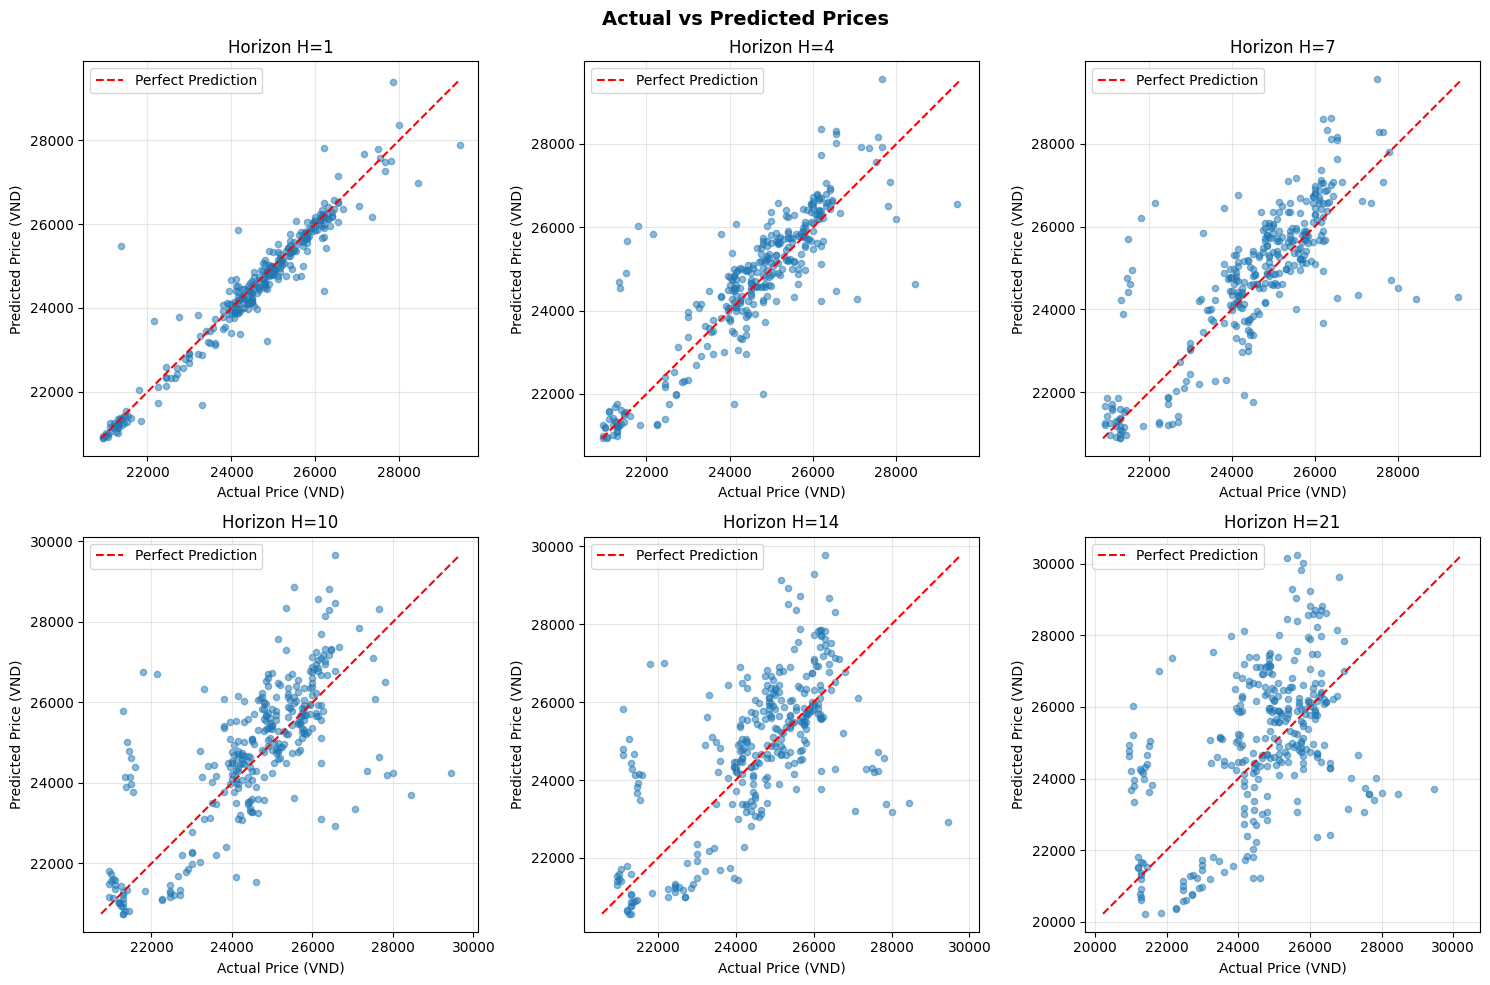

In [55]:
# Tính pred_prices trước khi plot
pred_prices = np.zeros_like(all_preds)  # [N, 5]
for i in range(len(all_base_prices)):
    for j in range(len(H_LIST)):
        delta = all_base_prices[i] * all_preds[i, j]
        pred_prices[i, j] = all_base_prices[i] + delta

# Kiểm tra shape
print(f"pred_prices shape: {pred_prices.shape}")
print(f"all_actual_prices shape: {all_actual_prices.shape}")

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, h in enumerate(H_LIST):
    if i >= len(axes):
        break

    actual = all_actual_prices[:, i]
    pred = pred_prices[:, i]

    axes[i].scatter(actual, pred, alpha=0.5, s=20)

    # Đường perfect prediction
    min_val = min(actual.min(), pred.min())
    max_val = max(actual.max(), pred.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

    axes[i].set_xlabel('Actual Price (VND)')
    axes[i].set_ylabel('Predicted Price (VND)')
    axes[i].set_title(f'Horizon H={h}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Ẩn subplot thừa
if len(H_LIST) < len(axes):
    axes[-1].axis('off')

plt.suptitle('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

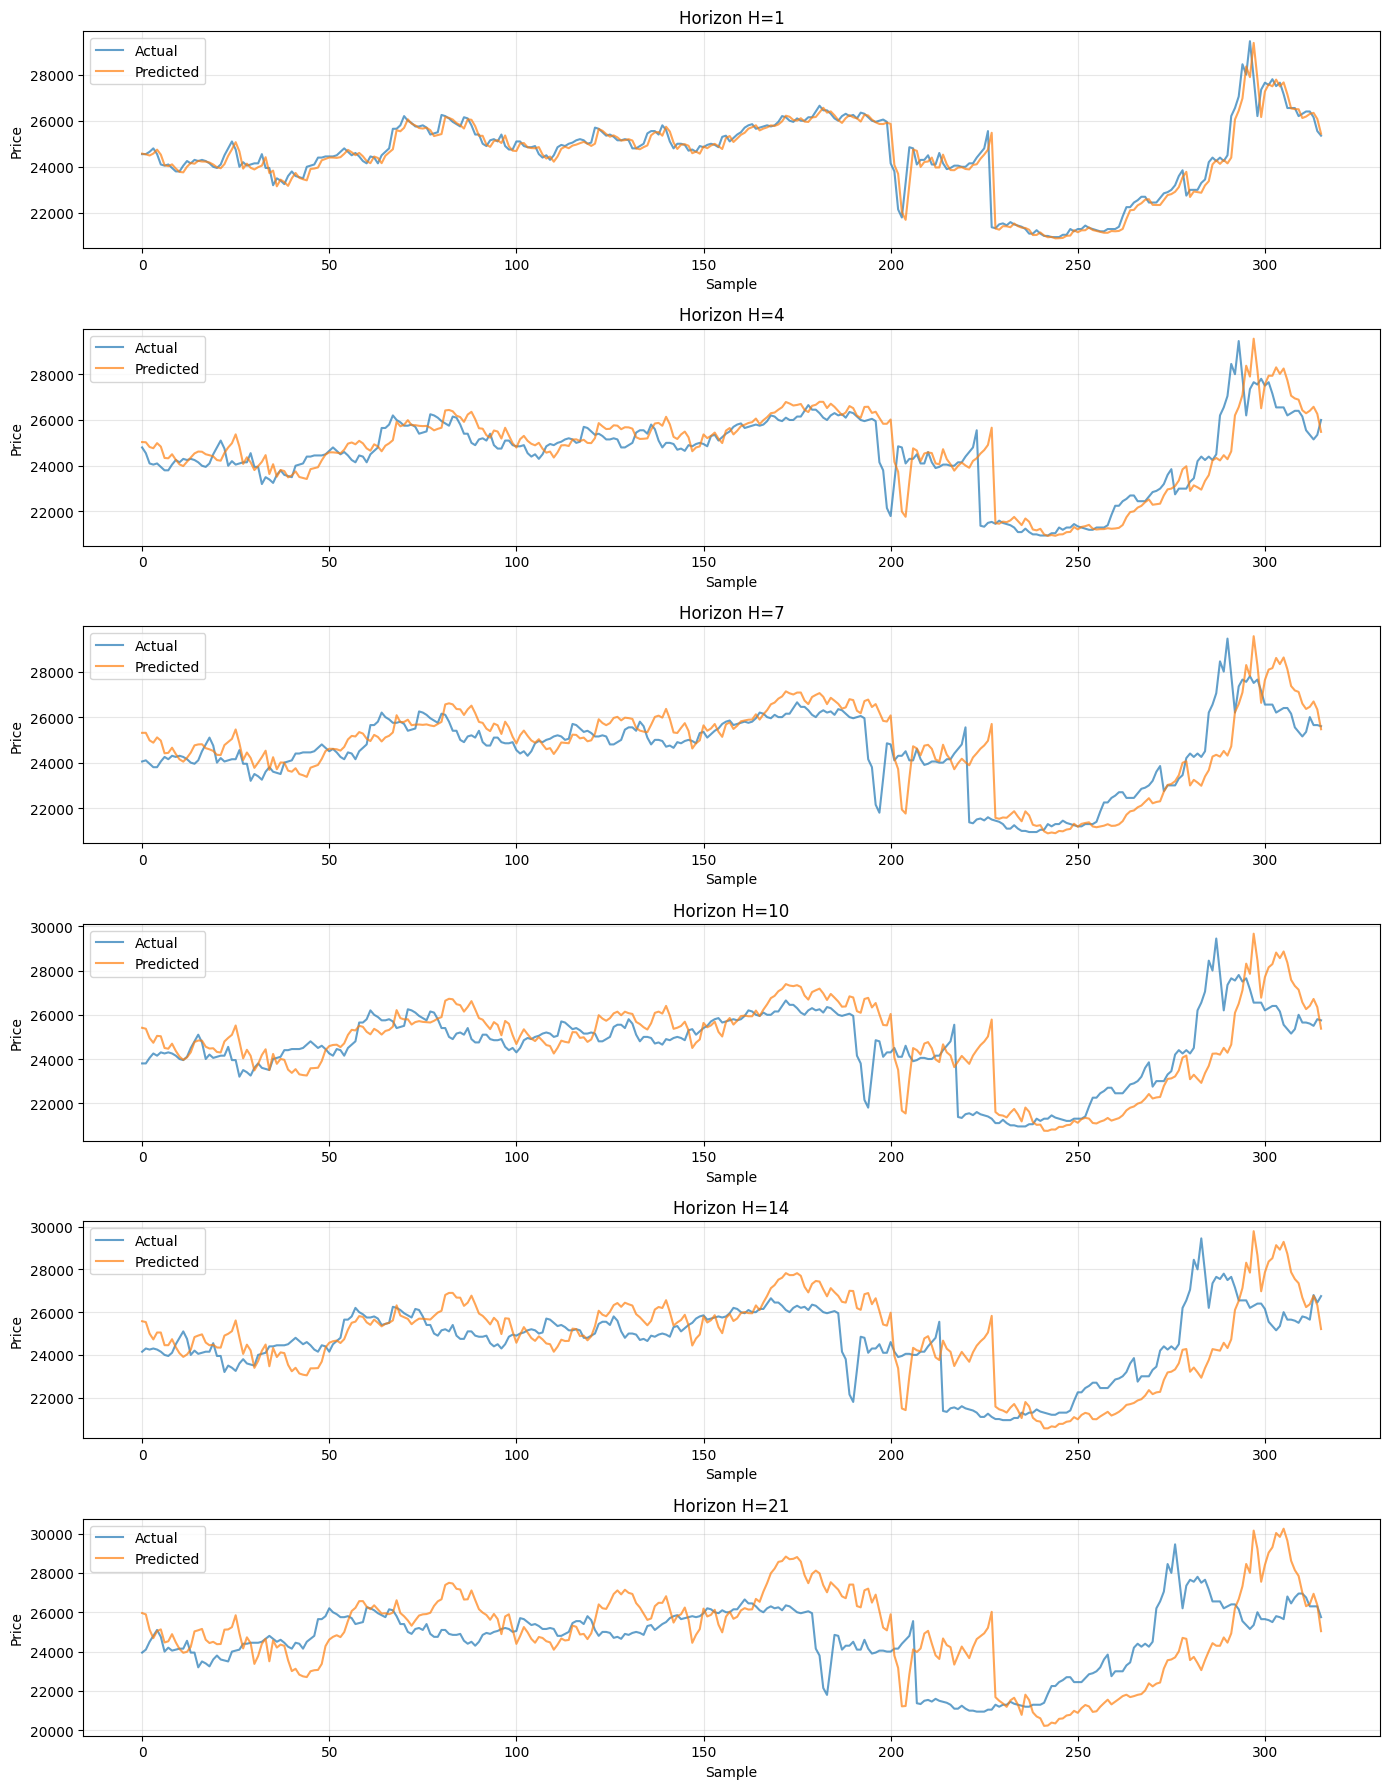

In [56]:
# Plot predictions vs actual cho một vài horizons
fig, axes = plt.subplots(len(H_LIST), 1, figsize=(14, 3*len(H_LIST)))

for i, h in enumerate(H_LIST):
    ax = axes[i] if len(H_LIST) > 1 else axes

    pred_prices = all_base_prices * (1 + all_preds[:, i])
    actual_prices = all_actual_prices[:, i]

    ax.plot(actual_prices, label='Actual', alpha=0.7)
    ax.plot(pred_prices, label='Predicted', alpha=0.7)
    ax.set_title(f'Horizon H={h}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##Cross Attention

In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import numpy as np

print("\n=== TEST SET RESULTS (ACTUAL PRICE - VND) ===")

for i, h in enumerate(H_LIST):
    pred_returns  = all_preds[:, i]
    actual_returns = all_targets[:, i]

    # Chuyển sang giá
    pred_prices   = all_base_prices * (1 + pred_returns)
    actual_prices = all_actual_prices[:, i]

    # MAE, RMSE, R2 trên PRICE
    mae_price  = mean_absolute_error(actual_prices, pred_prices)
    rmse_price = root_mean_squared_error(actual_prices, pred_prices)
    r2_price   = r2_score(actual_prices, pred_prices)

    # Chuẩn hoá theo giá trung bình (normalized error)
    mean_price = np.mean(actual_prices)
    mae_norm   = mae_price / mean_price
    rmse_norm  = rmse_price / mean_price

    # MAPE trên PRICE
    mape = np.mean(np.abs((actual_prices - pred_prices) / actual_prices)) * 100

    print(
        f"H= {h:>2}: "
        f"MAE={mae_price:,.2f} VND | "
        f"RMSE={rmse_price:,.2f} VND | "
        f"MAE_norm={mae_norm:.5f} | "
        f"RMSE_norm={rmse_norm:.5f} | "
        f"MAPE={mape:.2f}% | "
        f"R2={r2_price:.5f}"
    )


=== TEST SET RESULTS (ACTUAL PRICE - VND) ===
H=  1: MAE=243.25 VND | RMSE=447.21 VND | MAE_norm=0.00992 | RMSE_norm=0.01823 | MAPE=0.99% | R2=0.92272
H=  4: MAE=539.45 VND | RMSE=859.35 VND | MAE_norm=0.02198 | RMSE_norm=0.03502 | MAPE=2.21% | R2=0.71575
H=  7: MAE=694.33 VND | RMSE=1,059.68 VND | MAE_norm=0.02828 | RMSE_norm=0.04316 | MAPE=2.85% | R2=0.56950
H= 10: MAE=865.19 VND | RMSE=1,247.42 VND | MAE_norm=0.03522 | RMSE_norm=0.05078 | MAPE=3.55% | R2=0.40560
H= 14: MAE=1,105.36 VND | RMSE=1,526.17 VND | MAE_norm=0.04494 | RMSE_norm=0.06204 | MAPE=4.54% | R2=0.12365
H= 21: MAE=1,374.57 VND | RMSE=1,835.23 VND | MAE_norm=0.05577 | RMSE_norm=0.07446 | MAPE=5.66% | R2=-0.23241


pred_prices shape: (316, 6)
all_actual_prices shape: (316, 6)


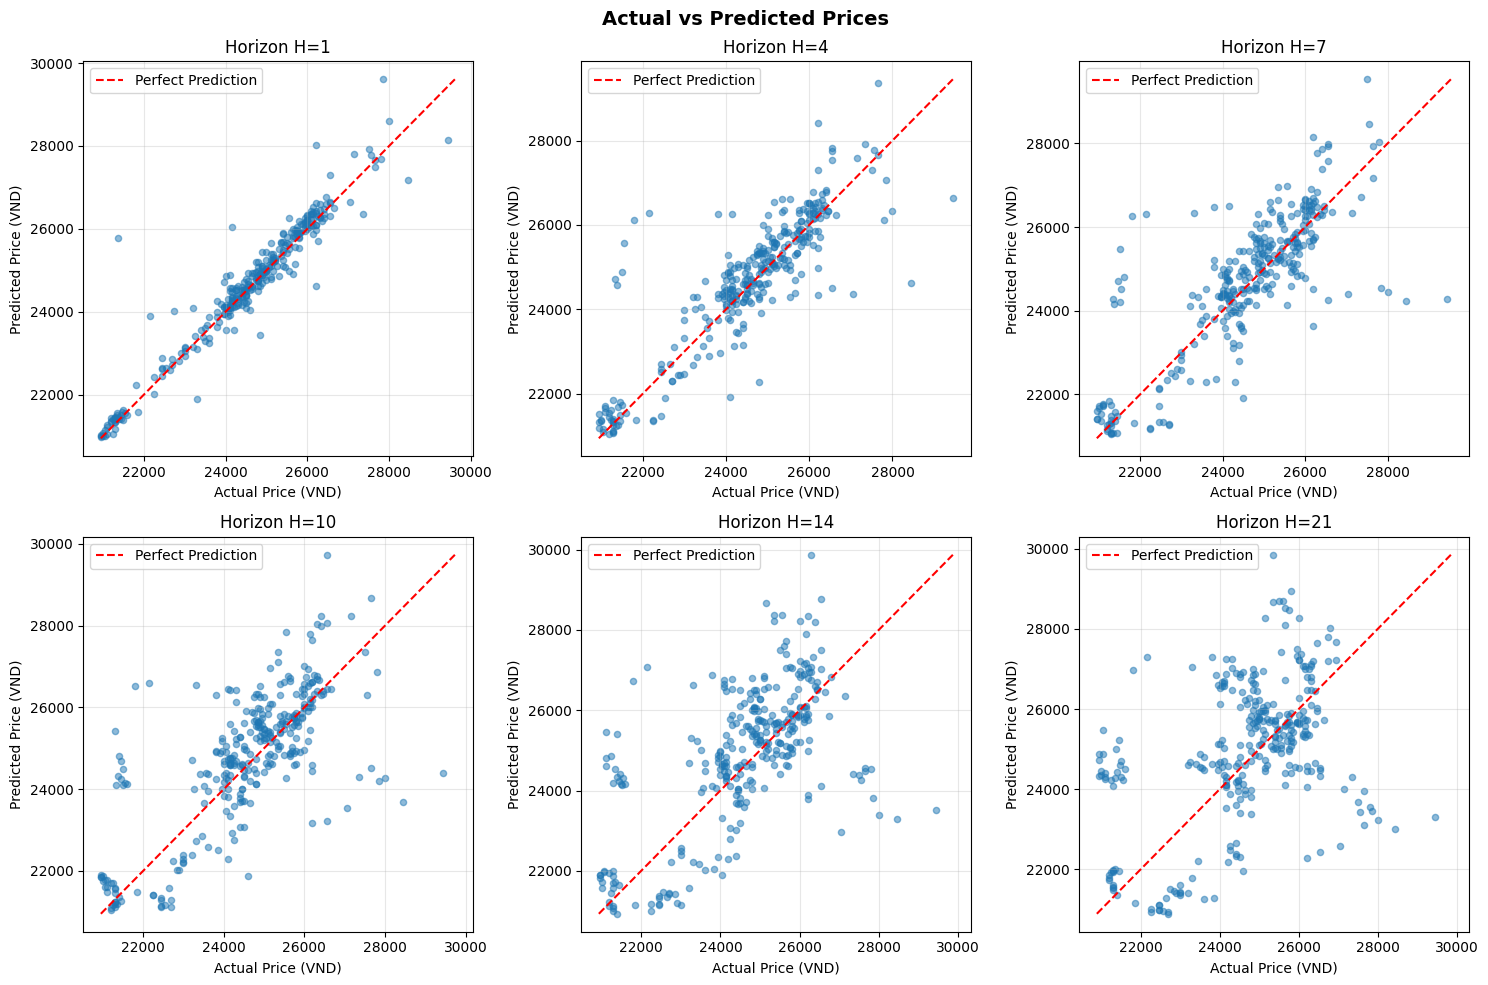

In [78]:
# Tính pred_prices trước khi plot
pred_prices = np.zeros_like(all_preds)  # [N, 5]
for i in range(len(all_base_prices)):
    for j in range(len(H_LIST)):
        delta = all_base_prices[i] * all_preds[i, j]
        pred_prices[i, j] = all_base_prices[i] + delta

# Kiểm tra shape
print(f"pred_prices shape: {pred_prices.shape}")
print(f"all_actual_prices shape: {all_actual_prices.shape}")

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, h in enumerate(H_LIST):
    if i >= len(axes):
        break

    actual = all_actual_prices[:, i]
    pred = pred_prices[:, i]

    axes[i].scatter(actual, pred, alpha=0.5, s=20)

    # Đường perfect prediction
    min_val = min(actual.min(), pred.min())
    max_val = max(actual.max(), pred.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

    axes[i].set_xlabel('Actual Price (VND)')
    axes[i].set_ylabel('Predicted Price (VND)')
    axes[i].set_title(f'Horizon H={h}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Ẩn subplot thừa
if len(H_LIST) < len(axes):
    axes[-1].axis('off')

plt.suptitle('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

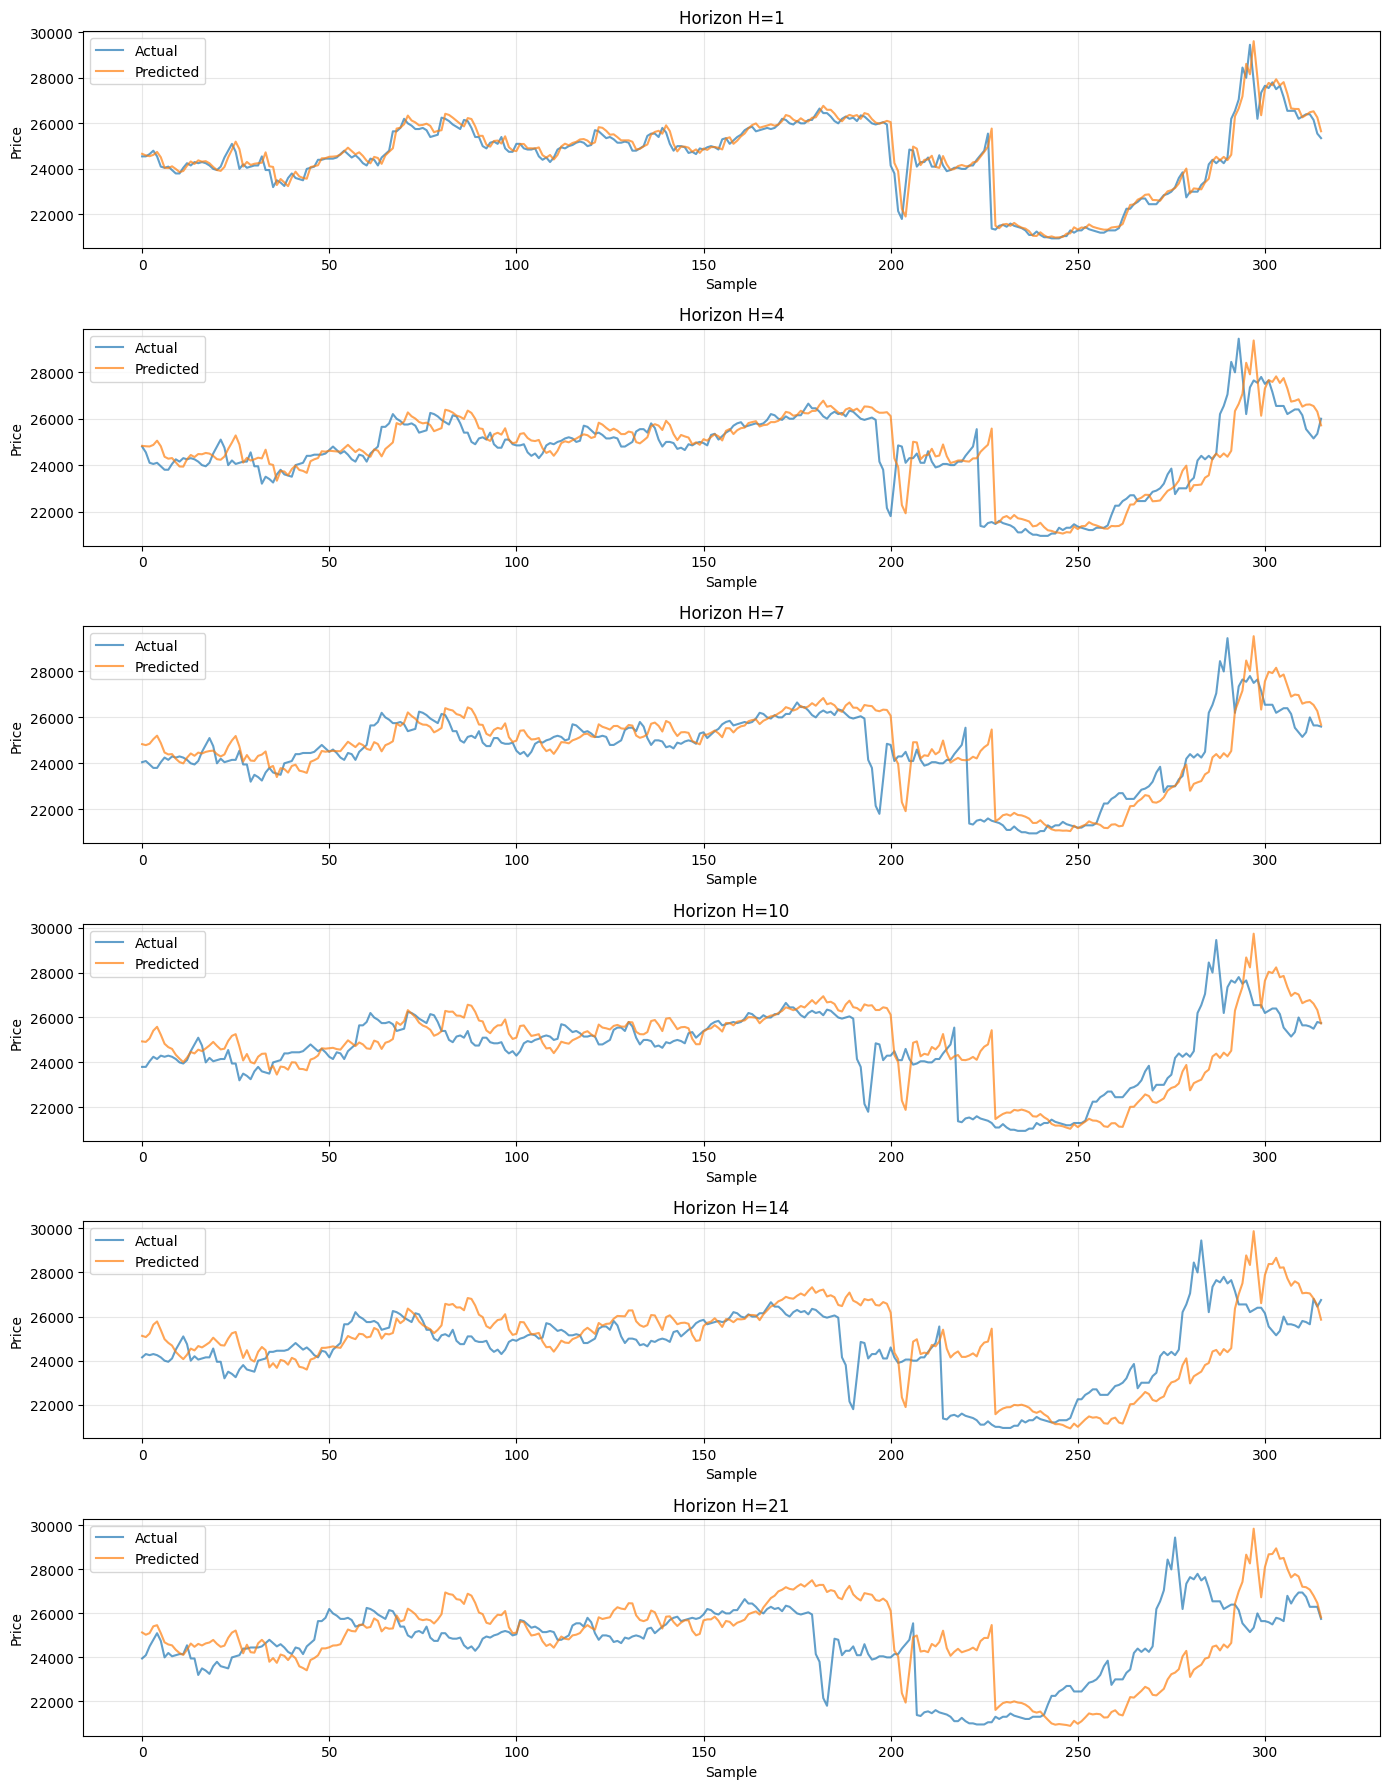

In [79]:
# Plot predictions vs actual cho một vài horizons
fig, axes = plt.subplots(len(H_LIST), 1, figsize=(14, 3*len(H_LIST)))

for i, h in enumerate(H_LIST):
    ax = axes[i] if len(H_LIST) > 1 else axes

    pred_prices = all_base_prices * (1 + all_preds[:, i])
    actual_prices = all_actual_prices[:, i]

    ax.plot(actual_prices, label='Actual', alpha=0.7)
    ax.plot(pred_prices, label='Predicted', alpha=0.7)
    ax.set_title(f'Horizon H={h}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sample Predictions

##Fusion concatenate

In [57]:
print("\n" + "="*70)
print("SAMPLE PREDICTIONS (Last 5 samples)")
print("="*70)

for sample_idx in range(-5, 0):
    base_price = all_base_prices[sample_idx]
    print(f"\n📊 Sample {sample_idx}: Base Price = {base_price:,.0f} VND")
    print("-" * 60)

    for i, h in enumerate(H_LIST):
        pred_return = all_preds[sample_idx, i]
        actual_return = all_targets[sample_idx, i]
        actual_price = all_actual_prices[sample_idx, i]

        pred_delta = base_price * pred_return
        pred_price = base_price * (1 + pred_return)
        error = abs(actual_price - pred_price)
        error_pct = error / actual_price * 100

        direction = "📈" if pred_return > 0 else "📉"

        print(f"  H={h:2d}: cumulative_return={pred_return:+.4f} ({pred_return*100:+.2f}%) {direction}")
        print(f"         Delta={pred_delta:+,.0f} VND")
        print(f"         Actual={actual_price:>10,.0f} VND | Pred={pred_price:>10,.0f} VND | Error={error:>7,.0f} VND ({error_pct:.2f}%)")


SAMPLE PREDICTIONS (Last 5 samples)

📊 Sample -5: Base Price = 26,300 VND
------------------------------------------------------------
  H= 1: cumulative_return=-0.0045 (-0.45%) 📉
         Delta=-119 VND
         Actual=    26,400 VND | Pred=    26,181 VND | Error=    219 VND (0.83%)
  H= 4: cumulative_return=-0.0002 (-0.02%) 📉
         Delta=-6 VND
         Actual=    25,550 VND | Pred=    26,294 VND | Error=    744 VND (2.91%)
  H= 7: cumulative_return=+0.0022 (+0.22%) 📈
         Delta=+58 VND
         Actual=    25,350 VND | Pred=    26,358 VND | Error=  1,008 VND (3.98%)
  H=10: cumulative_return=-0.0017 (-0.17%) 📉
         Delta=-44 VND
         Actual=    25,650 VND | Pred=    26,256 VND | Error=    606 VND (2.36%)
  H=14: cumulative_return=-0.0025 (-0.25%) 📉
         Delta=-66 VND
         Actual=    25,750 VND | Pred=    26,234 VND | Error=    484 VND (1.88%)
  H=21: cumulative_return=+0.0003 (+0.03%) 📈
         Delta=+7 VND
         Actual=    26,750 VND | Pred=    26,307 VND

##Cross Attention

In [80]:
print("\n" + "="*70)
print("SAMPLE PREDICTIONS (Last 5 samples)")
print("="*70)

for sample_idx in range(-5, 0):
    base_price = all_base_prices[sample_idx]
    print(f"\n📊 Sample {sample_idx}: Base Price = {base_price:,.0f} VND")
    print("-" * 60)

    for i, h in enumerate(H_LIST):
        pred_return = all_preds[sample_idx, i]
        actual_return = all_targets[sample_idx, i]
        actual_price = all_actual_prices[sample_idx, i]

        pred_delta = base_price * pred_return
        pred_price = base_price * (1 + pred_return)
        error = abs(actual_price - pred_price)
        error_pct = error / actual_price * 100

        direction = "📈" if pred_return > 0 else "📉"

        print(f"  H={h:2d}: cumulative_return={pred_return:+.4f} ({pred_return*100:+.2f}%) {direction}")
        print(f"         Delta={pred_delta:+,.0f} VND")
        print(f"         Actual={actual_price:>10,.0f} VND | Pred={pred_price:>10,.0f} VND | Error={error:>7,.0f} VND ({error_pct:.2f}%)")


SAMPLE PREDICTIONS (Last 5 samples)

📊 Sample -5: Base Price = 26,300 VND
------------------------------------------------------------
  H= 1: cumulative_return=+0.0025 (+0.25%) 📈
         Delta=+65 VND
         Actual=    26,400 VND | Pred=    26,365 VND | Error=     35 VND (0.13%)
  H= 4: cumulative_return=+0.0116 (+1.16%) 📈
         Delta=+305 VND
         Actual=    25,550 VND | Pred=    26,605 VND | Error=  1,055 VND (4.13%)
  H= 7: cumulative_return=+0.0136 (+1.36%) 📈
         Delta=+356 VND
         Actual=    25,350 VND | Pred=    26,656 VND | Error=  1,306 VND (5.15%)
  H=10: cumulative_return=+0.0162 (+1.62%) 📈
         Delta=+425 VND
         Actual=    25,650 VND | Pred=    26,725 VND | Error=  1,075 VND (4.19%)
  H=14: cumulative_return=+0.0295 (+2.95%) 📈
         Delta=+776 VND
         Actual=    25,750 VND | Pred=    27,076 VND | Error=  1,326 VND (5.15%)
  H=21: cumulative_return=+0.0339 (+3.39%) 📈
         Delta=+891 VND
         Actual=    26,750 VND | Pred=    27,1

# Save Model

In [81]:
model_type = "crossattn" if USE_CROSS_ATTENTION else "concat"

save_dict = {
    'model_state_dict': best_model_state,
    'best_L': best_L,
    'scaler_robust': scaler_robust,
    'scaler_close': scaler_close,
    'features_robust': features_robust,
    'feature_cols': feature_cols,
    'horizons': H_LIST,
    'use_text': USE_TEXT,
    'use_cross_attention': USE_CROSS_ATTENTION,
    'embedding_model_name': MODEL_NAME,
    'embedding_dim': EMBEDDING_DIM,
    'num_news_days': NEWS_LOOKBACK_DAYS,
    'd_model': D_MODEL,
    'n_heads': N_HEADS,
    'num_encoder_layers': NUM_ENCODER_LAYERS,
    'patch_len': PATCH_LEN,
    'stride': STRIDE,
    'dropout': DROPOUT
}

model_short_name = MODEL_NAME.split("/")[-1].lower().replace("-", "_")
filename = f'patchtst_{model_short_name}_{model_type}_L{best_L}.pth'
torch.save(save_dict, filename)

print(f"\nModel saved as '{filename}'")


Model saved as 'patchtst_vietnamese_embedding_crossattn_L24.pth'


# Comparison: Cross-Attention and Concatenate Normally

To compare, you can:
1. Run the notebook with `USE_ATTENTION = True`
2. Run again with `USE_ATTENTION = False`
3. Compare the metrics